In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Facial expression

/content/drive/MyDrive/Facial expression


In [ ]:
import tarfile

fname = 'fer2013.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot

In [ ]:
df=pd.read_csv('fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
np.array(df.pixels.loc[0].split(' ')).reshape(48,48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

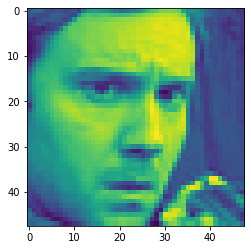

In [ ]:
pyplot.imshow(np.array(df.pixels.loc[0].split(' ')).reshape(48,48).astype('float'))

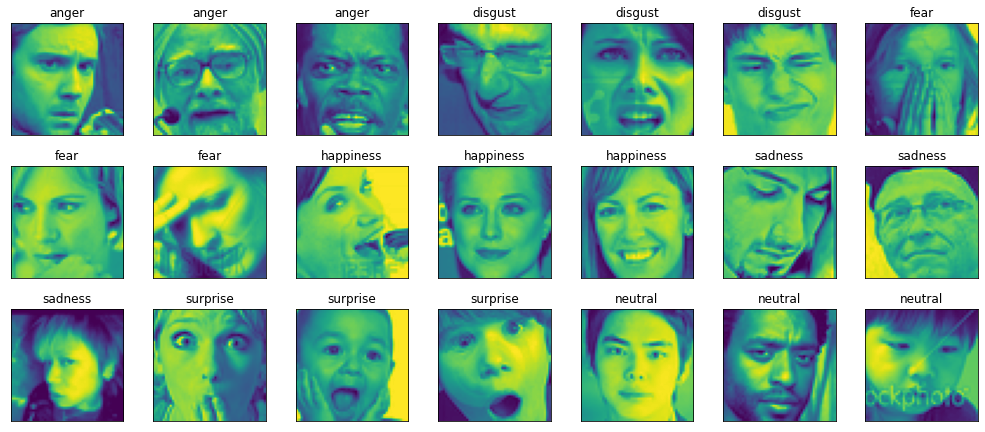

In [ ]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [ ]:
img_array = df.pixels.apply(lambda x : np.array(x.split(' ')).reshape(48,48,1).astype('float32'))

In [ ]:
img_array = np.stack(img_array,axis=0)

In [ ]:
labels = df.emotion.values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(img_array,labels,test_size=.1)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((32298, 48, 48, 1), (32298,), (3589, 48, 48, 1), (3589,))

In [ ]:
X_train = X_train/255
X_test = X_test/255 

In [ ]:
basemodel=tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = (48,48,1)),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      #
                                      tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (48,48,1)),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      #
                                      tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape = (48,48,1)),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      #
                                      tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape = (48,48,1)),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(1000,activation='relu'),
                                      tf.keras.layers.Dense(7,activation='softmax')
                                      ])

In [ ]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.0001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics =['accuracy'])

In [ ]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [ ]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')

In [ ]:
basemodel.fit(X_train,y_train, epochs=50,validation_split=.2,callbacks=call_back)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


808/808 [==============================] - ETA: 0s - loss: 1.8166 - accuracy: 0.2508
Epoch 1: val_accuracy improved from -inf to 0.25062, saving model to checkpoint/best_model.h5
808/808 [==============================] - 17s 9ms/step - loss: 1.8166 - accuracy: 0.2508 - val_loss: 1.8095 - val_accuracy: 0.2506
Epoch 2/50
804/808 [============================>.] - ETA: 0s - loss: 1.7717 - accuracy: 0.2720
Epoch 2: val_accuracy improved from 0.25062 to 0.27322, saving model to checkpoint/best_model.h5
808/808 [==============================] - 6s 7ms/step - loss: 1.7715 - accuracy: 0.2721 - val_loss: 1.7547 - val_accuracy: 0.2732
Epoch 3/50
803/808 [============================>.] - ETA: 0s - loss: 1.6528 - accuracy: 0.3522
Epoch 3: val_accuracy improved from 0.27322 to 0.34226, saving model to checkpoint/best_model.h5
808/808 [==============================] - 5s 6ms/step - loss: 1.6525 - accuracy: 0.3523 - val_loss: 1.6511 - val_accuracy: 0.3423
Epoch 4/50
803/808 [=====================

In [ ]:
X_train.shape

(32298, 48, 48, 1)

actual label is anger
1/1 [==============================] - 0s 20ms/step
predicted label is anger


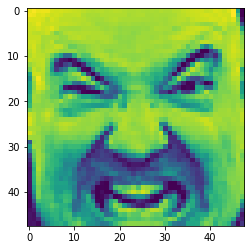

In [ ]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time
for k in range(40):
  print(f'actual label is {label_to_text[y_test[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot. imshow(X_test[k].reshape((48,48)))
  pyplot.show()
  time.sleep(5)
  clear_output(wait=True)
